# cifar10 classification task




## Q & A 

### What are "local invariant" and "parameter sharing" ?
           
- Local Connectivity: 
> we connect each neuron to only a local region of the input volume. The spatial extent of this connectivity is a hyperparameter called the receptive field of the neuron (equivalently this is the filter size). The connections are local in space (along width and height), but always full along the entire depth of the input volume.

- Parameter sharing: 
> Parameter sharing scheme is used in Convolutional Layers to control the number of parameters. If a filter with specified parameters is given to every neuron in the same depth slice of the output volume, the number of the total parameters is too high to put into practice.
we are going to constrain the neurons in each depth slice to use the same weights and bias provided that if one feature is useful to compute at some spatial position $(x_1,y_1)$, then it should also be useful to compute at a different position $(x_2,y_2)$. In practice during backpropagation, every neuron in the volume will compute the gradient for its weights, but these gradients will be added up across each depth slice and only update a single set of weights per slice.
















### Why we use batch normalization ?            

> It alleviates a lot of headaches with properly initializing neural networks by explicitly forcing the activations throughout a network to take on a unit gaussian distribution at the beginning of the training. The core observation is that this is possible because normalization is a simple differentiable operation. In the implementation, applying this technique usually amounts to insert the BatchNorm layer immediately after fully connected layers (or convolutional layers), and before non-linearities.

In practice networks that use Batch Normalization are significantly more robust to bad initialization. Additionally, batch normalization can be interpreted as doing preprocessing at every layer of the network, but integrated into the network itself in a differentiable manner.

### What problem does dropout try to solve ?

Dropout is an extremely effective, simple and recently introduced regularization technique. While training, dropout is implemented by only keeping a neuron active with some probability p (a hyperparameter), or setting it to zero otherwise.

## Practice

### Dataset description

The dataset used in this session is the cifar10 which contains 50000 color (RGB) images, each with size 32x32x3.  All 50000 images are classified into ten categories. 

### Approach 1: Construct a CNN model with the help of keras API

#### 1 import libraries & data preprocessing 





In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
import os
import numpy as np
import matplotlib.pyplot as plt


(x_train,y_train),(x_test,y_test) = tf.keras.datasets.cifar10.load_data()
x_test = (x_test - np.mean(x_train, axis=0)) / np.max(x_train, axis=0)
x_train = (x_train - np.mean(x_train, axis=0)) / np.max(x_train, axis=0)

# print(x_train.shape)
# print(x_train[:1])
print(x_train.shape)
print(y_test.shape)


(50000, 32, 32, 3)
(10000, 1)


In [ ]:
# display some example data (optional)
for i in range(31,41):
    plt.subplot(2,5,i - 30)
    plt.imshow(x_train[i-1])
    plt.text(3,10,str(y_train[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

#### 2 Design a CNN model  

In [ ]:
model = Sequential([
      Conv2D(16, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
      MaxPooling2D(strides=(2,2)),
      Conv2D(32, 3, padding='same', activation='relu'),
      MaxPooling2D(strides=(2,2)),
      Conv2D(32, 3, padding='same', activation='relu'),
      MaxPooling2D(strides=(2,2)),
      Dropout(0.2),
      Flatten(),
      Dense(64, activation='relu'),
      Dense(10),
      
])

model.compile(optimizer='adam',
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'])

model.summary()

#### 3 train the data

Epoch 1/10
1094/1094 [==============================] - 11s 4ms/step - loss: 1.7977 - accuracy: 0.3415 - val_loss: 1.3192 - val_accuracy: 0.5343
Epoch 2/10
1094/1094 [==============================] - 4s 3ms/step - loss: 1.2789 - accuracy: 0.5390 - val_loss: 1.1368 - val_accuracy: 0.5986
Epoch 3/10
1094/1094 [==============================] - 4s 4ms/step - loss: 1.1126 - accuracy: 0.6035 - val_loss: 1.0268 - val_accuracy: 0.6331
Epoch 4/10
1094/1094 [==============================] - 4s 4ms/step - loss: 0.9969 - accuracy: 0.6466 - val_loss: 0.9547 - val_accuracy: 0.6645
Epoch 5/10
1094/1094 [==============================] - 4s 3ms/step - loss: 0.9320 - accuracy: 0.6735 - val_loss: 0.9123 - val_accuracy: 0.6791
Epoch 6/10
1094/1094 [==============================] - 4s 4ms/step - loss: 0.8849 - accuracy: 0.6891 - val_loss: 0.9083 - val_accuracy: 0.6823
Epoch 7/10
1094/1094 [==============================] - 4s 3ms/step - loss: 0.8319 - accuracy: 0.7079 - val_loss: 0.8516 - val_accuracy

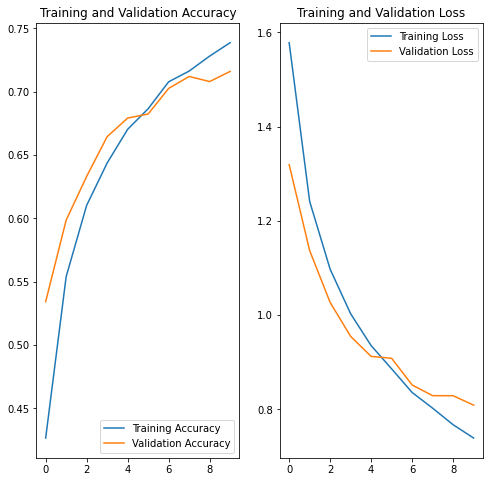

In [8]:
epochs = 10
history = model.fit(x_train, y_train, batch_size=32, epochs=epochs, validation_split=0.3)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 4 evaluate the model

In [9]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

313/313 - 0s - loss: 0.8147 - accuracy: 0.7172


### Approach 2: Use MobileNetV2 as a fixed feature extractor firstly and further fine-tune part of the base model 

#### 1 load dataset using tensorflow_datasets

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteW1IZU6/cifar10-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteW1IZU6/cifar10-test.tfrecord
Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


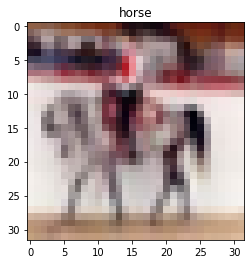

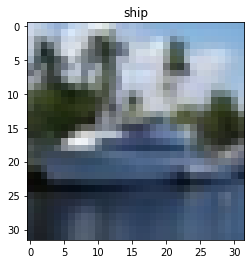

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
import os
import numpy as np
import matplotlib.pyplot as plt

tfds.disable_progress_bar()
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cifar10',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  # plt.figure(figsize=(3,3))
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

IMG_SIZE = 96 # All images will be resized to 96 x 96

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)


#### 2 construct a new model based on a MobileNexV2 pretrained on ImageNet datasets

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)


# dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

base_model = tf.keras.applications.MobileNetV2(input_shape=(96, 96, 3), weights='imagenet', include_top=False)
base_model.trainable = False
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(512),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(128),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Softmax()
])
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

base_model.summary()
model.summary()


#### 3 training

In [12]:
history = model.fit(train_batches,
          epochs=10,
          validation_data=validation_batches)

Epoch 1/10
1250/1250 [==============================] - 26s 19ms/step - loss: 4.4865 - accuracy: 0.3868 - val_loss: 4.0547 - val_accuracy: 0.8308
Epoch 2/10
1250/1250 [==============================] - 19s 15ms/step - loss: 4.2640 - accuracy: 0.6052 - val_loss: 4.0387 - val_accuracy: 0.8396
Epoch 3/10
1250/1250 [==============================] - 19s 15ms/step - loss: 4.2579 - accuracy: 0.6105 - val_loss: 4.0206 - val_accuracy: 0.8548
Epoch 4/10
1250/1250 [==============================] - 19s 15ms/step - loss: 4.2460 - accuracy: 0.6252 - val_loss: 4.0185 - val_accuracy: 0.8572
Epoch 5/10
1250/1250 [==============================] - 19s 15ms/step - loss: 4.2470 - accuracy: 0.6272 - val_loss: 4.0216 - val_accuracy: 0.8534
Epoch 6/10
1250/1250 [==============================] - 19s 15ms/step - loss: 4.2401 - accuracy: 0.6361 - val_loss: 4.0162 - val_accuracy: 0.8582
Epoch 7/10
1250/1250 [==============================] - 19s 15ms/step - loss: 4.2414 - accuracy: 0.6353 - val_loss: 4.0117 -

#### 4 plot the training learning curves

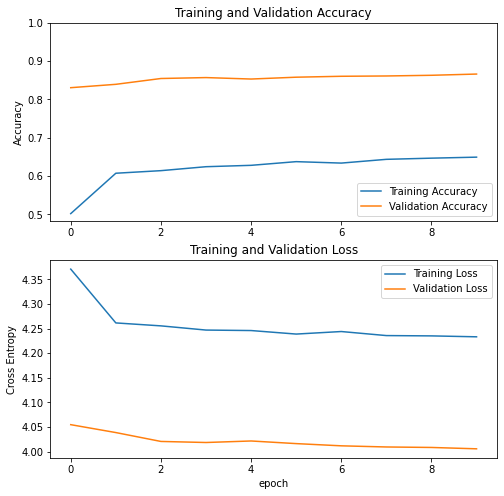

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

why the validation  metrics looks clearly better than the training metrics?
> 1. BN and Dropout layers can actually affect the training process while turned off during the validation process.
> 2. the operation of validation is after the training process and the result of training metrics is calculated average over an single but complete epoch. Therefore, the validation metrics may see a trained-longer model compared to the one training metrics can examinate.

#### 5 evaluate the performance on test data

In [15]:
model.evaluate(test_batches)

157/157 [==============================] - 2s 10ms/step - loss: 4.0121 - accuracy: 0.8566


[4.012089252471924, 0.8565999865531921]

#### 6 Further fine-tune 

Number of layers in the base model:  154
Epoch 10/20
1250/1250 [==============================] - 40s 28ms/step - loss: 4.3419 - accuracy: 0.5847 - val_loss: 4.0022 - val_accuracy: 0.8660
Epoch 11/20
1250/1250 [==============================] - 34s 27ms/step - loss: 4.2586 - accuracy: 0.6313 - val_loss: 3.9929 - val_accuracy: 0.8736
Epoch 12/20
1250/1250 [==============================] - 34s 27ms/step - loss: 4.2401 - accuracy: 0.6471 - val_loss: 3.9799 - val_accuracy: 0.8868
Epoch 13/20
1250/1250 [==============================] - 34s 27ms/step - loss: 4.2291 - accuracy: 0.6579 - val_loss: 3.9749 - val_accuracy: 0.8940
Epoch 14/20
1250/1250 [==============================] - 35s 28ms/step - loss: 4.2289 - accuracy: 0.6597 - val_loss: 3.9677 - val_accuracy: 0.8990
Epoch 15/20
1250/1250 [==============================] - 34s 27ms/step - loss: 4.2217 - accuracy: 0.6694 - val_loss: 3.9644 - val_accuracy: 0.9022
Epoch 16/20
1250/1250 [==============================] - 35s 28ms/step - loss

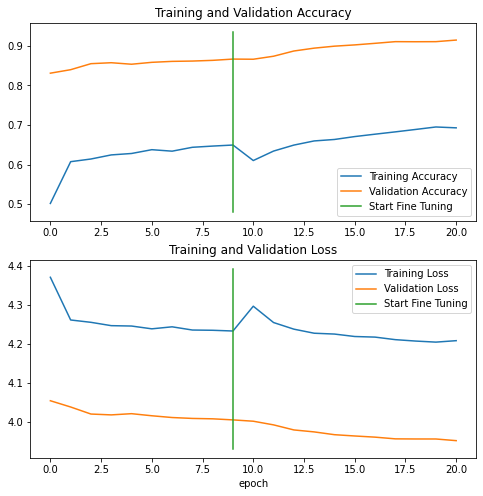

In [16]:
print("Number of layers in the base model: ", len(base_model.layers))
base_model.trainable = True

fine_tune_from = 30
# Freeze all the layers before the `fine_tune_from` layer
for layer in base_model.layers[:fine_tune_from]:
  layer.trainable =  False

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
      metrics=['accuracy'])
# model.summary()

fine_tune_epochs = 10
total_epochs =  10 + fine_tune_epochs

history_fine = model.fit(train_batches,
              epochs=total_epochs,
              initial_epoch=history.epoch[-1],
              validation_data=validation_batches)


acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([10-1,10-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([10-1,10-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### 7 evaluate the fine-tuned performance on test data

In [17]:
model.evaluate(test_batches)

157/157 [==============================] - 2s 10ms/step - loss: 3.9555 - accuracy: 0.9106


[3.9555327892303467, 0.9106000065803528]

#### 8 predict explicitly

In [19]:
for img, labl in test_batches.take(5):
  print("predict: ", np.argmax(model(img), axis=-1))
  print("truth  : ", labl.numpy())
  print('----------------------------------------------------------------')

predict:  [2 6 7 5 2 8 2 0 8 4 5 9 5 0 1 6 7 8 5 8 9 4 8 0 5 9 2 9 7 4 8 4]
truth  :  [2 6 7 3 2 8 2 0 0 4 5 9 5 0 1 6 7 8 4 8 9 4 8 0 5 9 2 9 7 4 8 4]
----------------------------------------------------------------
predict:  [2 0 9 2 0 8 9 4 9 5 4 2 8 3 5 6 8 9 9 6 6 4 0 3 9 2 9 3 3 3 2 6]
truth  :  [2 0 9 2 0 8 0 4 9 5 4 2 8 3 5 6 8 9 9 4 6 4 0 2 9 2 9 3 3 3 0 6]
----------------------------------------------------------------
predict:  [6 4 6 9 2 8 6 2 8 1 7 2 1 8 8 6 9 1 2 9 9 5 4 4 3 1 2 0 0 1 7 6]
truth  :  [6 4 6 9 2 8 3 2 8 1 7 2 1 8 8 6 9 1 4 9 9 5 4 4 3 9 2 0 0 1 3 6]
----------------------------------------------------------------
predict:  [7 6 3 0 3 9 3 1 4 4 8 2 0 2 9 1 9 2 3 7 8 0 1 3 5 6 9 1 2 6 9 8]
truth  :  [7 6 3 0 3 9 5 1 4 4 8 2 0 2 9 1 9 2 7 7 8 0 1 3 4 6 9 1 4 6 9 8]
----------------------------------------------------------------
predict:  [2 3 5 8 6 8 8 7 3 6 8 2 9 7 7 9 3 3 3 9 4 1 2 3 9 6 3 5 3 0 9 2]
truth  :  [2 5 5 8 3 8 8 8 3 6 8 2 9 7 7 9 3 3 5 9 4 1 2

### Result:

#### Approach 1: 71.72%                
#### Approach 2: 
- feature extractor stage: 85.66% 
- fine-tune stage: 91.06%